# Імпорт необхідних бібліотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max.rows',130)
pd.set_option('display.max.columns',130)
pd.set_option('float_format', '{:.2f}'.format)

# Імпорт даних

Вмонтуємо наш диск, якщо Ви працюєте в Google Colab. Якщо працюєте локально, пропустіть наступну клітинку.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Знайдемо, де лежать наші файли з даними. В мене вони знаходяться тут:

In [ ]:
# !ls drive/MyDrive/Machine\ Learning\ для\ людей/data/credit

Зчитуємо дані.

In [ ]:
df = pd.read_csv("application_data.csv.zip")

In [ ]:
# Огляд декількох записів з датафрейму
df.head()

# Перевірка структури даних

In [ ]:
df.info(verbose = True, show_counts = True)

In [ ]:
df.shape

Маємо ~307k рядків та 122 колонки.

## Статистичний звіт для числових змінних

In [ ]:
df.describe()

# Аналіз категоріальних змінних

In [ ]:
df.select_dtypes(include = "object").columns

In [ ]:
# Перевірка кількості категоріальних змінних
len(df.select_dtypes(include = "object").columns)

Дані містять 16 `categorical` змінних

# Аналіз числових змінних

In [ ]:
number_df = df.select_dtypes(include="number")

In [ ]:
number_df.columns

In [ ]:
# Перевірка кількості числових змінних
len(number_df.columns)

Дані міcтять 106 `numerical` змінних

In [ ]:
number_df.head()

# Робота з некоректними типами даних

Перевірка, чи немає у нас стовпця з неправильним типом даних

In [ ]:
df.dtypes

Дивлячись на дані та відповідні їм типи даних, можна змінити

1.   Елемент списку
2.   Елемент списку

тип стовпчика SKU.

In [ ]:
df['SK_ID_CURR'] = df['SK_ID_CURR'].astype("str")

Також ми можемо змінити всі стовпці `flag` на тип даних, який є більш економний для зберігання.

Ось скільки пам'яті в Мб займають наші дані зараз.

In [ ]:
df.memory_usage().sum()/1024/1024

Отже, ми можемо потенційно заощадити 57 Мб пам'яті! І трансформувати наш фрейм даних буде простіше. Давайте змінимо тип.


In [ ]:
flag_cols = ['flag' in col.lower() for col in df.columns]

In [ ]:
df[df.columns[flag_cols]].head()

In [ ]:
df[df.columns[flag_cols]].nunique()

Типи даних в pandas взяті з numpy, і ось тут список всіх типів даних в numpy:

https://numpy.org/doc/stable/user/basics.types.html

Кожен тип даних займає певну кількість байт у пам'яті. Давайте з'ясуємо, скільки займає 1 тип int8 та 1 тип int64 і скільки пам'яті ми заощадимо, якщо змінимо тип.

In [ ]:
import numpy as np
from sys import getsizeof

In [ ]:
getsizeof(np.int64(1))

In [ ]:
getsizeof(np.int8(1))

In [ ]:
7 * df.shape[0] * sum(flag_cols) / 1024 / 1024

In [ ]:
str_flag_cols = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

In [ ]:
for col in str_flag_cols:
  df[col] = np.where(df[col]=='Y', 1, 0)

In [ ]:
df[str_flag_cols].nunique()

In [ ]:
df[df.columns[flag_cols]] = df[df.columns[flag_cols]].astype('int8')

In [ ]:
df.memory_usage().sum()/1024/1024

# Робота з пропущеними значеннями

Найпростіше емпіричне правило для опрацювання пропущених значень: якщо пропущених значень більше за 40% - видаляємо колонку, якщо менше за 40% - аналізуємо, як можна заповнити і чи треба.

Зазвичай, якщо відсоток пропущених даних більший за 10 і немає чіткої (яка значно виділяється) моди (найчастішого) значення в даних, то лишаємо дані як є до використання методів машинного навчання. Далі якщо метод вимагає заповення пропущених значень, можемо експериментувати із заповеннями. Також хорошою практикою є створити окрему колонку-флаг (0/1), яка вказує, де були пропущені значення - це буде додаткова ознака для моделі.


Перевіримо, чи немає нульових значень в нашому наборі даних

In [ ]:
df.isnull().values.any()

Порахуємо загальну кількість нульових значень в наборі даних

In [ ]:
df.isnull().values.sum()

Сформуємо список із стовпців з нульовими значеннями

In [ ]:
df.columns[df.isnull().any()]

In [ ]:
len(df.columns[df.isnull().any()])

Усього `67` стовпців мають одне або більше NULL-значень в даних

## Кількість та відсоток пропущених значень у стовпцях

In [ ]:
null_count = df.isnull().sum()
null_percentage = round((df.isnull().sum()/df.shape[0])*100, 2)

In [ ]:
null_df = pd.DataFrame({'column_name' : df.columns,'null_count' : null_count,'null_percentage': null_percentage})
null_df.reset_index(drop = True, inplace = True)

In [ ]:
null_df.sort_values(by = 'null_percentage', ascending = False)

## Видалення стовпців з NULL значеннями > 40%

Сформуємо список стовпців з NULL значеннями > 40% у список. Ми видалимо ці стовпці з датафрейму, оскільки в них занадто багато пропущених значень.

In [ ]:
columns_to_be_deleted = null_df[null_df['null_percentage'] > 40].column_name.to_list()

In [ ]:
len(columns_to_be_deleted)

Всього потрібно видалити `49` стовпців. Видалення їх з основного датафрейму **`df`**

In [ ]:
df.drop(columns = columns_to_be_deleted, inplace = True)

Перевірка підрахунку стовпців після видалення. Мало б залишитись лише `73` стовпці

In [ ]:
df.shape

## Перевірка стовпців з NULL значеннями < 40%

Створення датафрейму `null_df_under40` зі стовпцями, де відсоток пропущених значеннь менше 40%

In [ ]:
null_df_under40 = null_df[null_df['null_percentage'] < 40]

In [ ]:
null_df_under40.sort_values(by = 'null_percentage', ascending = False)

Опрацюємо кожну з колонок.

### Аналіз стовпця `OCCUPATION_TYPE`

- нульові значення = 31.35%

In [ ]:
df['OCCUPATION_TYPE'].value_counts()

Заміна NULL-значень на категорією `Unknown`

In [ ]:
df.fillna({'OCCUPATION_TYPE': 'Unknown'}, inplace=True)

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(data = df, x = "OCCUPATION_TYPE")
plt.xticks(rotation = 90)
plt.show()

**Спостереження**
- Якщо поглянути на графік, то найбільшу кількість заявників на кредит мають `Laborers`
- Для імпутації краще залишити дані як є (пропущені значення становлять 31,35%) і не проводити імпутацію за якоюсь константою, як-от мода або мін/макс медіана, якщо це числовий стовпчик, оскільки це може викривити дані в подальших розрахунках.

Існує також можливість імпутації за допомогою більш "розумних" методів, але ми вивчимо їх пізніше, а зараз ми робимо те, що можемо, за допомогою деяких найпростіших перетворень.

### Аналіз стовпця `EXT_SOURCE_3`

- пропущені значення = 19.83%

In [ ]:
df.EXT_SOURCE_3.value_counts().head()

In [ ]:
sns.boxplot(df.EXT_SOURCE_3)
plt.show()

Отримання процентильних значень для `EXT_SOURCE_3`

In [ ]:
df.EXT_SOURCE_3.quantile(q = [0.25,0.5,0.75,1])

Найбільш повторюване значення в `EXT_SOURCE_3

In [ ]:
df.EXT_SOURCE_3.mode()[0]

Перевірка середнього значення `EXT_SOURCE_3`

In [ ]:
df.EXT_SOURCE_3.mean()

**Спостереження**
-  Дивлячись на діагараму розмаху, медіана становить 0,535276
-  Найчастіше повторюване значення - 0,74630
-  Середнє значення - 0,51085
-  Хоча середнє та медіана є ближчими і можуть бути використані для імпутації, оскільки відсутнє відсоткове значення є більшим (19,83%), краще залишити дані як є і не проводити імпутації. Якщо метод вимагає імпутації, ми можемо імпутувати дані за допомогою медіани і створити ще один стовпчик, в якому буде позначено, які значення були імпутовані.

# ДЗ 1. Аналіз стовпців `AMT_REQ_CREDIT_BUREAU` з пропущеними значеннями

Виведіть середнє, моду, медіану та відсоток відсутніх даних для настуних колонок:

- `AMT_REQ_CREDIT_BUREAU_YEAR`
-	`AMT_REQ_CREDIT_BUREAU_MON`
-	`AMT_REQ_CREDIT_BUREAU_WEEK`

На основі виведених даних напишіть висновок про те, чи варто заповнювати пусті значення і якщо так, то яким чином?

## Аналіз стовпця `AMT_REQ_CREDIT_BUREAU_YEAR`

- нульові значення = 13.50%

Виведіть середнє, моду, медіану та відсоток відсутніх даних.

На основі виведених даних напишіть висновок про те, чи варто заповнювати пусті значення і якщо так, то яким чином?

In [ ]:
df['AMT_REQ_CREDIT_BUREAU_YEAR'].value_counts()

In [ ]:
df['AMT_REQ_CREDIT_BUREAU_YEAR'].head()

In [ ]:
sns.boxplot(df.AMT_REQ_CREDIT_BUREAU_YEAR)
plt.show()

In [ ]:
df.AMT_REQ_CREDIT_BUREAU_YEAR.quantile(q = [0.25,0.5,0.75,1])

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(data = df, x = "AMT_REQ_CREDIT_BUREAU_YEAR")
plt.xticks(rotation = 90)
plt.show()

In [ ]:
df.AMT_REQ_CREDIT_BUREAU_YEAR.mode()[0]

In [ ]:
df.AMT_REQ_CREDIT_BUREAU_YEAR.mean()

**Спостереження**
-  Дивлячись на діагараму розмаху, медіана становить 1.00
-  Найчастіше повторюване значення - 0,0
-  Середнє значення - 1.899974435321363
- На боксплоті видно, що є багато викидів, які становлять невеликий відсоток даних, але впливають на середнє
-  Cереднє та медіана дуже відрізняються одне від одного. Тому для імпутації краще використати медіану. Оскільки відсутнє відсоткове значення становить 13,50%, краще залишити дані як є і не проводити імпутації. Якщо метод вимагає імпутації, ми можемо імпутувати дані за допомогою мемдіани, тому що вона менш чутлива до викидів і створити ще один стовпчик, в якому буде позначено, які значення були імпутовані.

## Аналіз стовпця `AMT_REQ_CREDIT_BUREAU_MON`

- нульові значення = 13.50%

Виведіть середнє, моду, медіану та відсоток відсутніх даних.
На основі виведених даних напишіть висновок про те, чи варто заповнювати пусті значення і якщо так, то яким чином?


In [109]:
df['AMT_REQ_CREDIT_BUREAU_MON'].value_counts()

AMT_REQ_CREDIT_BUREAU_MON
0.00     222233
1.00      33147
2.00       5386
3.00       1991
4.00       1076
5.00        602
6.00        343
7.00        298
9.00        206
8.00        185
10.00       132
11.00       119
12.00        77
13.00        72
14.00        40
15.00        35
16.00        23
17.00        14
18.00         6
19.00         3
24.00         1
23.00         1
27.00         1
22.00         1
Name: count, dtype: int64

In [110]:
df['AMT_REQ_CREDIT_BUREAU_MON'].head()

0   0.00
1   0.00
2   0.00
3    NaN
4   0.00
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: float64

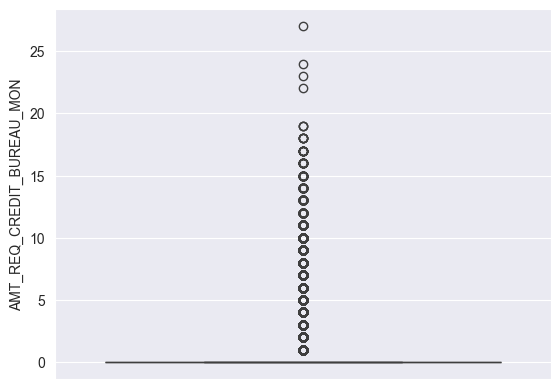

In [111]:
sns.boxplot(df.AMT_REQ_CREDIT_BUREAU_MON)
plt.show()

In [121]:
df.AMT_REQ_CREDIT_BUREAU_MON.quantile(q = [0.25,0.5,0.75, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,  1])

0.25    0.00
0.50    0.00
0.75    0.00
0.80    0.00
0.90    1.00
0.91    1.00
0.92    1.00
0.93    1.00
0.94    1.00
0.95    1.00
0.96    1.00
0.97    2.00
0.98    2.00
0.99    4.00
1.00   27.00
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: float64

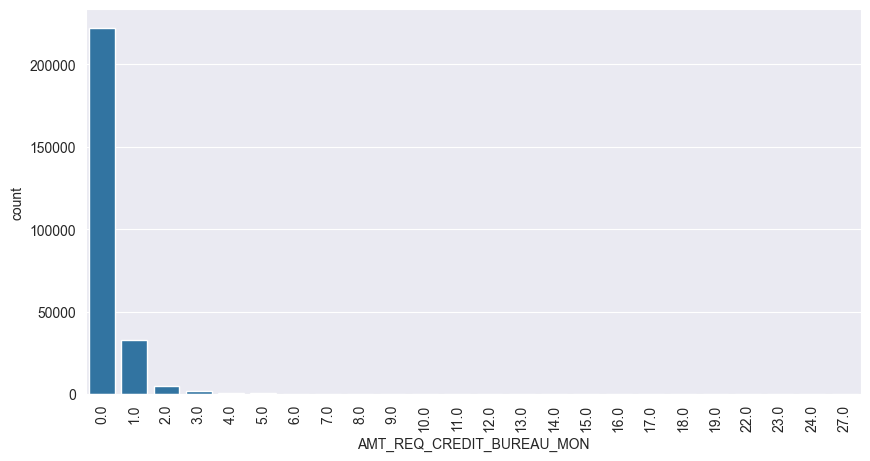

In [113]:
plt.figure(figsize = (10,5))
sns.countplot(data = df, x = "AMT_REQ_CREDIT_BUREAU_MON")
plt.xticks(rotation = 90)
plt.show()

In [114]:
df.AMT_REQ_CREDIT_BUREAU_MON.mode()[0]

0.0

In [116]:
df.AMT_REQ_CREDIT_BUREAU_MON.mean()

0.26739526000781977

**Спостереження**
-  Дивлячись на діагараму розмаху, медіана становить 0.0
-  Найчастіше повторюване значення - 0,0
-  Середнє значення - 0.26739526000781977
- На боксплоті виндо, що є багато викидів, які становлять невеликий відсоток даних, але впливають на середнє. По суті дані повністю складаються з викидів, а найчастіше значення - 0. Також видно, що більша частина ненульових значень знаходиться у 0.99 персентилі.
-  Cереднє та медіана відрізняються одне від одного. Тому для імпутації краще використати медіану. Оскільки відсутнє відсоткове значення становить 13,50%, краще залишити дані як є і не проводити імпутації. Якщо метод вимагає імпутації, ми можемо імпутувати дані за допомогою мемдіани, тому що вона менш чутлива до викидів і створити ще один стовпчик, в якому буде позначено, які значення були імпутовані.

## Аналіз стовпця `AMT_REQ_CREDIT_BUREAU_WEEK`

- нульові значення = 13.50%

Виведіть середнє, моду, медіану та відсоток відсутніх даних.
На основі виведених даних напишіть висновок про те, чи варто заповнювати пусті значення і якщо так, то яким чином?

In [106]:
df['AMT_REQ_CREDIT_BUREAU_WEEK'].value_counts()

AMT_REQ_CREDIT_BUREAU_WEEK
0.00    257456
1.00      8208
2.00       199
3.00        58
4.00        34
6.00        20
5.00        10
8.00         5
7.00         2
Name: count, dtype: int64

In [107]:
df['AMT_REQ_CREDIT_BUREAU_WEEK'].head()

0   0.00
1   0.00
2   0.00
3    NaN
4   0.00
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: float64

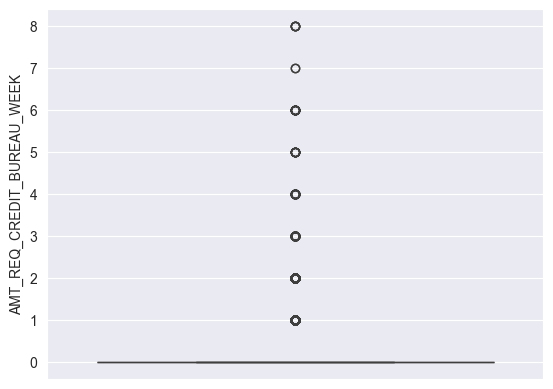

In [117]:
sns.boxplot(df.AMT_REQ_CREDIT_BUREAU_WEEK)
plt.show()

In [122]:
df.AMT_REQ_CREDIT_BUREAU_WEEK.quantile(q = [0.25,0.5,0.75, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,  1])

0.25   0.00
0.50   0.00
0.75   0.00
0.80   0.00
0.90   0.00
0.91   0.00
0.92   0.00
0.93   0.00
0.94   0.00
0.95   0.00
0.96   0.00
0.97   1.00
0.98   1.00
0.99   1.00
1.00   8.00
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: float64

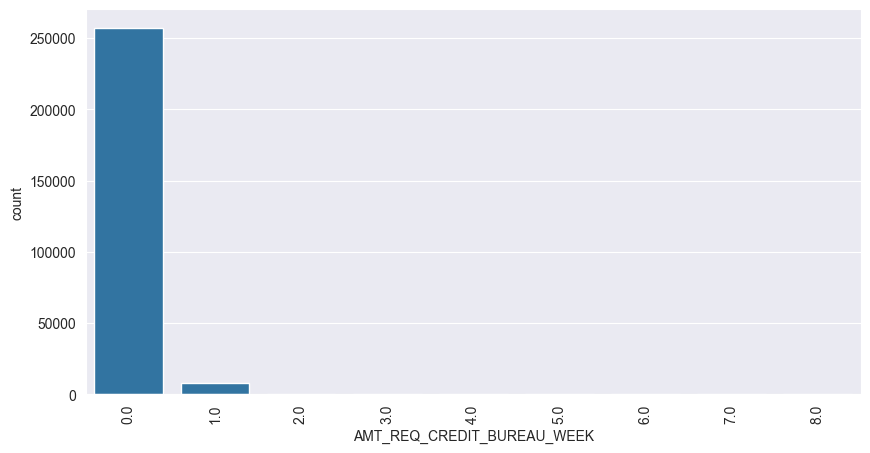

In [123]:
plt.figure(figsize = (10,5))
sns.countplot(data = df, x = "AMT_REQ_CREDIT_BUREAU_WEEK")
plt.xticks(rotation = 90)
plt.show()

In [124]:
df.AMT_REQ_CREDIT_BUREAU_WEEK.mode()[0]

0.0

In [127]:
df.AMT_REQ_CREDIT_BUREAU_WEEK.mean()

0.0343619356973142

**Спостереження**
-  Дивлячись на діагараму розмаху, медіана становить 0.0
-  Найчастіше повторюване значення - 0,0
-  Середнє значення - 0.0343619356973142
- На боксплоті виндо, що є багато викидів, які становлять великий відсоток даних, і впливають на середнє. По суті дані повністю складаються з викидів, а найчастіше значення - 0. Також видно, що більша частина ненульових значень знаходиться у 0.99 персентилі.
-  Cереднє та медіана відрізняються одне від одного. Тому для імпутації краще використати медіану. Оскільки відсутнє відсоткове значення становить 13,50%, краще залишити дані як є і не проводити імпутації. Якщо метод вимагає імпутації, ми можемо імпутувати дані за допомогою мемдіани, тому що вона менш чутлива до викидів і створити ще один стовпчик, в якому буде позначено, які значення були імпутовані.

## Перевірка стовпців зі значеннями NULL > 0% та < 1%

Створення датафрейму `null_df_under1` з відсотком пропущених значень > 0% та < 1% у кожному стовпці

In [ ]:
null_df_under1 = null_df[(null_df['null_percentage'] > 0) & (null_df['null_percentage'] < 1)]

In [ ]:
null_df_under1.sort_values(by = 'null_percentage', ascending = False)

### Аналіз стовпця `NAME_TYPE_SUITE`

In [ ]:
null_df_under1[null_df_under1.column_name == 'NAME_TYPE_SUITE']

In [ ]:
df['NAME_TYPE_SUITE'].value_counts()

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(data = df, x = "NAME_TYPE_SUITE")
plt.xticks(rotation = 90)
plt.show()

**Спостереження**
-   Дивлячись на графік, категорія `Unaccompanied` має найбільшу кількість заявників на отримання кредиту. Отже, більшість позичальників наважуються звертатися за кредитом без супроводу.
- Ми можемо продовжити імпутацію `Unaccompanied` в датафреймі, але краше надати перевагу другому варіанту.
- Ми також могли б імпутувати дані зі значенням `NA`, оскільки ця колонка є категоричною.
- Аналогічно, якщо в колонці не вистачає менше 1% даних, ми можемо її опустити. Але якщо ми вилучимо всі дані в усіх стовпчиках, де пропущено <=1% даних, ми можемо вилучити занадто багато даних. Тому я здебільшого зберігаю дані настільки, наскільки це можливо.

In [ ]:
df['NAME_TYPE_SUITE'].fillna('NA', inplace=True)

### Аналіз стовпця `OBS_30_CNT_SOCIAL_CIRCLE`

In [ ]:
null_df_under1[null_df_under1.column_name == 'OBS_30_CNT_SOCIAL_CIRCLE']

In [ ]:
df.OBS_30_CNT_SOCIAL_CIRCLE.value_counts().head(10)

In [ ]:
sns.boxplot(df.OBS_30_CNT_SOCIAL_CIRCLE)
plt.show()

Розрахунок перцентилів `OBS_30_CNT_SOCIAL_CIRCLE`

In [ ]:
df.OBS_30_CNT_SOCIAL_CIRCLE.quantile(q = [0.25,0.5,0.75,1])

Найбільш повторюване значення в `OBS_30_CNT_SOCIAL_CIRCLE`

In [ ]:
df.OBS_30_CNT_SOCIAL_CIRCLE.mode()[0]

Середнє значення `OBS_30_CNT_SOCIAL_CIRCLE`

In [ ]:
df.OBS_30_CNT_SOCIAL_CIRCLE.mean()

**Спостереження**
- Дивлячись на діаграму розмаху, медіана дорівнює 0.0
- Найчастіше повторюване значення - 0.0
- Середнє значення - 1,4222
- Є два викидні значення на рівні 50 та 350.
- Медіана і мода близькі (з огляду на діапазон даних у цьому стовпчику) і можуть бути використані для імпутації. Це не призведе до зміщення, оскільки відсоток пропущених значень невеликий (0,33%)

In [ ]:
df['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(df['OBS_30_CNT_SOCIAL_CIRCLE'].median(), inplace=True)

# ДЗ 2. Аналіз і заповнення пустих значень у колонках з малим відсотком пропущених

За прикладом вище проведіть аналіз пропущених значень в колонках
- EXT_SOURCE_2
- AMT_GOODS_PRICE

Для швидшого аналізу рекомендую написати фукнцію, яку Ви зможете викликати для кожної з колонок.

Зробіть висновок, що робити з пропущеними значеннями в кожному випадку і виконанайте ту дію, яку зазначили.

# Робота з неправильними/невідомими значеннями даних

### Аналіз стовпця `CODE_GENDER`

Перевірка діапазону значень

In [ ]:
df['CODE_GENDER'].value_counts()

Стать має бути тільки чоловіча або жіноча. Значення `XNA` може вказувати на те, що значення не було надано заявником або пропущено кредитним спеціалістом, який перевіряє заявку

In [ ]:
df[df['CODE_GENDER'] == 'XNA']

Оскільки дані виглядають достовірними, ми перевіримо можливість застосування методу імпутації.
- Заявників-жінок удвічі більше, ніж заявників-чоловіків
- Отже, ми прирівняємо `CODE_GENDER` до 'F'

In [ ]:
df['CODE_GENDER'] = df['CODE_GENDER'].apply(lambda x: 'F' if x == 'XNA' else x)

Перевірка, чи вилучено `XNA`

In [ ]:
df['CODE_GENDER'].value_counts()

### Аналіз стовпця `DAYS_BIRTH`

In [ ]:
df['DAYS_BIRTH'].value_counts().head()

Існує ~17K+ унікальних записів, всі з яких, схоже, мають від'ємні значення

In [ ]:
df['DAYS_BIRTH'].unique()

In [ ]:
df['DAYS_BIRTH'].nunique()

In [ ]:
df['DAYS_BIRTH'].describe()

Перетворення `Days Birth` на додатні дні

In [ ]:
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x: -x if x < 0 else x)

In [ ]:
df['DAYS_BIRTH'].value_counts()

Всі дні в `DAYS_BIRTH` мають додатні значення - це може бути зручніше для аналізу.

#### Створимо нову колонку `YEARS_BIRTH` для зручності аналізу

In [ ]:
df['YEARS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x: round(x/365))

### Аналіз стовпця `NAME_FAMILY_STATUS`

Перевірка діапазону значень

In [ ]:
df['NAME_FAMILY_STATUS'].value_counts()

Стать має бути тільки чоловіча або жіноча. Значення `Unknown` може означати, що значення не було вказане заявником або пропущене кредитним спеціалістом, який перевіряє заявку

In [ ]:
df[df['NAME_FAMILY_STATUS'] == 'Unknown']

In [ ]:
df['NAME_FAMILY_STATUS'].value_counts(normalize = True) * 100

Оскільки дані виглядають достовірними, ми продовжимо перевірку методу імпутації.
- Одружені заявники складають понад 63% заявників.
- Отже, ми прирівняємо `NAME_FAMILY_STATUS` до `Married`.

In [ ]:
df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].apply(lambda x: 'Married' if x == 'Unknown' else x)

Перевірка чи вилучено `Unknown`

In [ ]:
df['NAME_FAMILY_STATUS'].value_counts()

### Аналіз стовпця`DAYS_EMPLOYED`

In [ ]:
df['DAYS_EMPLOYED'].value_counts().head()

In [ ]:
df['DAYS_EMPLOYED'].value_counts(normalize = True) * 100

In [ ]:
len(df[df['DAYS_EMPLOYED'] < 365243])

In [ ]:
df[df['DAYS_EMPLOYED'] < 365243].DAYS_EMPLOYED.value_counts()

In [ ]:
df['DAYS_EMPLOYED'].unique()

In [ ]:
df['DAYS_EMPLOYED'].nunique()

**Спостереження**
- Існує ~55K+ записів, для яких `DAYS_EMPLOYED` дорівнює 365243 дням
- Решта 252K+ записів мають від'ємне значення днів
- Існує 12 574 унікальних значень для `DAYS_EMPLOYED`

 - Колонка `DAYS_EMPLOYED` вказує на те, за скільки днів до подачі заявки особа почала поточну роботу, заявник/кредитний спеціаліст повинен ввести від'ємні значення, щоб вказати дні, що передують даті подачі заявки.<br>
 - Ми конвертуємо від'ємні значення в `DAYS_EMPLOYED` в додатні дні, щоб стандартизувати дні під час використання в розрахунках

In [ ]:
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: -x if x < 0 else x)

In [ ]:
df['DAYS_EMPLOYED'].value_counts().head()

Ми бачимо, що всі дні в `DAYS_EMPLOYED` мають додатні значення

**Для ~55K+ записів, для яких `DAYS_EMPLOYED` становить 365243 дні**
- Конвертуючи це в роки, ми отримуємо 1000 років, які фізично неможливо використати для працевлаштування заявника
- Це відповідає 18% даних і не може бути аномалією
- Вони можуть бути або пенсіонерами, або безробітними, і, дивлячись на дані, наш висновок є правильним

> Є два способи впоратися з цим
>> 1) Ми залишаємо дані такими, якими вони є, і враховуємо це під час аналізу АБО  <br>
>> 2) Ми розраховуємо середню кількість днів зайнятості без урахування цієї категорії та вписуємо її замість 365243 днів для пенсіонерів. <br>
>> Для безробітних кількість днів зайнятості може дорівнювати 0

*Примітка*
 - Під час розрахунків у цьому стовпчику ми повинні враховувати цей сценарій, оскільки інакше він спотворює наші результати

In [ ]:
df[df['DAYS_EMPLOYED'] == 365243].NAME_INCOME_TYPE.value_counts()

#### Створимо нову колонку `YEARS_EMPLOYED` для зручності аналізу

In [ ]:
df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: round(x/365))

### Аналіз стовпця `DAYS_REGISTRATION`

In [ ]:
df['DAYS_REGISTRATION'].value_counts().head()

In [ ]:
df['DAYS_REGISTRATION'].value_counts(normalize = True).head()

In [ ]:
df['DAYS_REGISTRATION'].unique()

In [ ]:
df['DAYS_REGISTRATION'].nunique()

Перетворення `DAYS_REGISTRATION` в додатні дні

In [ ]:
df['DAYS_REGISTRATION'] = df['DAYS_REGISTRATION'].apply(lambda x: -x if x < 0 else x)

In [ ]:
df['DAYS_REGISTRATION'].value_counts().head()

Всі дні в `DAYS_REGISTRATION` мають додатні значення

#### Створимо нову колонку `YEARS_REGISTRATION` для зручності аналізу

In [ ]:
df['YEARS_REGISTRATION'] = df['DAYS_REGISTRATION'].apply(lambda x: round(x/365))

### Аналіз стовпця `DAYS_ID_PUBLISH`

In [ ]:
df['DAYS_ID_PUBLISH'].value_counts().head()

In [ ]:
df['DAYS_ID_PUBLISH'].value_counts(normalize = True).head()

In [ ]:
df['DAYS_ID_PUBLISH'].unique()

In [ ]:
df['DAYS_ID_PUBLISH'].nunique()

Перетворення `DAYS_ID_PUBLISH` в додатні дні

In [ ]:
df['DAYS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].apply(lambda x: -x if x < 0 else x)

In [ ]:
df['DAYS_ID_PUBLISH'].value_counts().head()

Всі дні в `DAYS_ID_PUBLISH` мають додатні значення

#### Створимо нову колонку `YEARS_ID_PUBLISH` для зручності аналізу

In [ ]:
df['YEARS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].apply(lambda x: round(x/365))

### Аналіз стовпця `DAYS_LAST_PHONE_CHANGE`

In [ ]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts().head()

In [ ]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts(normalize = True).head()

In [ ]:
df['DAYS_LAST_PHONE_CHANGE'].unique()

In [ ]:
df['DAYS_LAST_PHONE_CHANGE'].nunique()

Перетворення `DAYS_LAST_PHONE_CHANGE` в додатні дні

In [ ]:
df['DAYS_LAST_PHONE_CHANGE'] = df['DAYS_LAST_PHONE_CHANGE'].apply(lambda x: -x if x < 0 else x)

In [ ]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts().head()

Всі дні в `DAYS_LAST_PHONE_CHANGE` мають додатні значення

#### Створення нової колонки `YEARS_LAST_PHONE_CHANGE` для зручності аналізу

In [ ]:
df['YEARS_LAST_PHONE_CHANGE'] = df['DAYS_LAST_PHONE_CHANGE'].apply(lambda x: round(x/365,0))

# Автоматичні функції

### Створення функції `age_cat` для категоризації `YEARS_BORNING`

In [ ]:
def age_cat(years):
    if years <= 20:
        return '0-20'
    elif years > 20 and years <= 30:
        return '20-30'
    elif years > 30 and years <= 40:
        return '30-40'
    elif years > 40 and years <= 50:
        return '40-50'
    elif years > 50 and years <= 60:
        return '50-60'
    elif years > 60 and years <= 70:
        return '60-70'
    elif years > 70:
        return '70+'

### Одномірний (категоріальний vs цільовий) та двомірний (категоріальний vs категоріальний) аналіз (гістограма) - категоріальні стовпчики

In [ ]:
import matplotlib.pyplot as plt


def bi_cat_countplot(df, column, hue_column):
    unique_hue_values = df[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,6)

    pltname = f'Нормалізований розподіл значень за категорією: {column}'
    proportions = df.groupby(hue_column)[column].value_counts(normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[0], title=pltname)

    # анотація значень в барплоті
    for container in ax.containers:
        ax.bar_label(container, fmt='{:,.1f}%')

    pltname = f'Кількість даних за категорією: {column}'
    counts = df.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[1], title=pltname)

    for container in ax.containers:
      ax.bar_label(container)


def uni_cat_target_compare(df, column):
    bi_cat_countplot(df, column, hue_column='TARGET' )


def bi_countplot_target(df0, df1, column, hue_column):
  pltname = 'Клієнт зі складнощами щодо платності'
  print(pltname.upper())
  bi_cat_countplot(df1, column, hue_column)
  plt.show()

  pltname = 'Клієнти зі своєчасними платежами'
  print(pltname.upper())
  bi_cat_countplot(df0, column, hue_column)
  plt.show()


### Обчислення мінімального та максимального діапазону відхилень для числових стовпців

In [ ]:
def outlier_range(dataset,column):
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    Min_value = (Q1 - 1.5 * IQR)
    Max_value = (Q3 + 1.5 * IQR)
    return Max_value

# Робота з викидами для числових стовпців

In [ ]:
import warnings

def dist_box(dataset, column):
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")

      plt.figure(figsize=(16,6))

      plt.subplot(1,2,1)
      sns.distplot(dataset[column], color = 'purple')
      pltname = 'Графік розподілу для ' + column
      plt.ticklabel_format(style='plain', axis='x')
      plt.title(pltname)

      plt.subplot(1,2,2)
      red_diamond = dict(markerfacecolor='r', marker='D')
      sns.boxplot(y = column, data = dataset, flierprops = red_diamond)
      pltname = 'Боксплот для ' + column
      plt.title(pltname)

      plt.show()

### Аналіз стовпця`CNT_CHILDREN`

In [ ]:
df['CNT_CHILDREN'].value_counts().sort_values(ascending = False).head()

In [ ]:
(df['CNT_CHILDREN'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

In [ ]:
dist_box(df,'CNT_CHILDREN')

Розрахуємо IQR (Inter Quartile range)

In [ ]:
Q1 = df['CNT_CHILDREN'].quantile(0.25)
Q3 = df['CNT_CHILDREN'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Значення *до* (Q1 - 1,5 * IQR) та *після* (Q3 + 1,5 * IQR) є викидами

In [ ]:
Min_value = (Q1 - 1.5 * IQR)
Max_value = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value))

**Спостереження**
- Дивлячись на дані, ми бачимо, що кількість заявників, які мають більше 7 дітей, є дуже мінімальною (2 або 3 в кожній категорії)
- Крім того, дивлячись на дані для заявників з 10 дітьми, заявники мають лише 31 й 41 рік відповідно. Це виглядає як одиничний випадок й може розглядатися як відхилення від норми
- Як дистрибутивні, так і діаграми розмаху чітко показують, що значення, які перевищують значення 2.5, є відхиленнями від норми.

**Висновок**
- Заявники, які мають 3 або більше дітей, є випадками, що відхиляються від норми. Ми можемо надати спеціальний аналіз для цих випадків.

### Аналіз стовпця `AMT_INCOME_TOTAL`

In [ ]:
df['AMT_INCOME_TOTAL'].value_counts().sort_values(ascending = False).head()

In [ ]:
(df['AMT_INCOME_TOTAL'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

In [ ]:
df['AMT_INCOME_TOTAL'].describe(percentiles = [0.75,0.99,0.999])

Побудуємо графік для `AMT_INCOME_TOTAL`

In [ ]:
dist_box(df,'AMT_INCOME_TOTAL')

- Графіки кінцевого результату дуже тонкі, й ми можемо спостерігати викид близько ~120 мільйонів.
- Давайте побудуємо графік, розглядаючи лише дохід нижче 99,9% значення, тобто 900 тисяч.

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.subplots(1,2 ,figsize = (20,8))

    plt.subplot(121)
    sns.distplot(df[df['AMT_INCOME_TOTAL'] < 900000].AMT_INCOME_TOTAL)
    pltname = 'Distplot of ' + 'AMT_INCOME_TOTAL'
    plt.title(pltname)

    plt.subplot(122)
    sns.boxplot(df[df['AMT_INCOME_TOTAL'] < 900000].AMT_INCOME_TOTAL)
    pltname = 'Boxplot of ' + 'AMT_INCOME_TOTAL'
    plt.title(pltname)

    plt.tight_layout(pad = 4)
    plt.show()

Тепер ми можемо чітко побачити розподіл і діапазон даних на обох графіках.
 - Це означає, що значення понад 900 тис. грн доходу явно є викидами

In [ ]:
df[df['AMT_INCOME_TOTAL'] > 900000].head()

**Спостереження**
- Дивлячись на дані, ми бачимо, що дохід понад 900 тис. грн (99,9% значення) є викидом
- Як діаграма розподілу, так і діаграма розмаху чітко показують нам ту саму тенденцію

**Висновок**
- Апліканти з доходом понад 900 тис. грн (99,9% значення) є викидами

# ДЗ 3. Аналіз викидів

Подібно до прикладу, проаналізуйте на викиди колонок
- `CNT_FAM_MEMBERS`
- `AMT_ANNUITY`

Зазначте, які значення в них можна вважати викидами.

# Розбиття на біни безперервних колонок для аналізу

### Категоризація стовпця `AMT_GOODS_PRICE

In [ ]:
df['AMT_GOODS_PRICE'].value_counts().sort_values(ascending = False).head()

In [ ]:
(df['AMT_GOODS_PRICE'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

Подивимось статистичний звіт для `AMT_GOODS_PRICE

In [ ]:
df['AMT_GOODS_PRICE'].describe(percentiles = [0.25,0.75,0.99,0.9999])

Розподілимо значення в `AMT_GOODS_PRICE` на 5 бінів і створимо новий стовпець `AMT_GOODS_PRICE_CATEGORY`.

In [ ]:
df['AMT_GOODS_PRICE_CATEGORY'] = pd.cut(df['AMT_GOODS_PRICE'],
                                        bins = 5, labels = ['very low', 'low', 'medium', 'high', 'very high'])

Перевірка заповнення значень згідно з очікуванням

In [ ]:
df['AMT_GOODS_PRICE_CATEGORY'].value_counts()

### Категоризація стовпця `YEARS_BIRTH`

Ми будемо класифікувати `YEARS_BIRTH` замість `DAYS_BIRTH`, оскільки роки легше інтерпретувати, ніж дні

In [ ]:
df['YEARS_BIRTH'].value_counts().sort_values(ascending = False).head()

In [ ]:
(df['YEARS_BIRTH'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

Подивимось статистичний звіт для  `YEARS_BIRTH`

In [ ]:
df['YEARS_BIRTH'].describe(percentiles = [0.25,0.75,0.99,0.9999])

Категоризуймо значення з `YEARS_BIRTH` у новий стовпець `YEARS_BIRTH_CATEGORY`.

In [ ]:
df['YEARS_BIRTH_CATEGORY'] = df['YEARS_BIRTH'].apply(age_cat)

Перевірка заповнення значень згідно з очікуванням

In [ ]:
df['YEARS_BIRTH_CATEGORY'].value_counts().sort_values(ascending = False)

### Категоризація стовпця `YEARS_REGISTRATION`

Ми будемо класифікувати `YEARS_REGISTRATION` замість `DAYS_REGISTRATION`, оскільки роки легше інтерпретувати, ніж дні

In [ ]:
df['YEARS_REGISTRATION'].value_counts().sort_values(ascending = False).head()

In [ ]:
(df['YEARS_REGISTRATION'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

Подивимось статистичний звіт для `YEARS_REGISTRATION`

In [ ]:
df['YEARS_REGISTRATION'].describe(percentiles = [0.25,0.75,0.99,0.9999])

Категоризуймо значення з `YEARS_REGISTRATION` в новий стовпець `YEARS_REGISTRATION_CATEGORY`.

In [ ]:
df['YEARS_REGISTRATION_CATEGORY'] = df['YEARS_REGISTRATION'].apply(age_cat)

Перевірка заповнення значень згідно з очікуванням

In [ ]:
df['YEARS_REGISTRATION_CATEGORY'].value_counts().sort_values(ascending = False)

# Зберігання оновлених даних зі стисненням

In [ ]:
filename = "drive/MyDrive/Machine Learning для людей/data/credit/application_data_processed"
compression_options = dict(method='zip', archive_name=f'{filename}.csv')
df.to_csv(f'{filename}.zip', compression=compression_options, index=False)

# Перевірка дисбалансу для цільового стовпця `TARGET`

### Аналіз стовпця `TARGET`

In [ ]:
df['TARGET'].value_counts().sort_values(ascending = False)

In [ ]:
df['TARGET'].value_counts(normalize = True).sort_values(ascending = False) * 100

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x = df['TARGET'], data = df)
plt.title('Перевірка коефіцієнта дисбалансу змінної TARGET')
plt.show()

**Спостереження**

- Ми маємо дисбаланс у змінній `TARGET` на основі % спостережень
 - Значення `TARGET` 1 - це клієнт, який має труднощі з оплатою (прострочення платежу більше ніж на X днів принаймні за одним з перших Y платежів за кредитом). Це лише 8,07% даних
 - Значення `TARGET` 0 - всі інші випадки, окрім 1. Це 91,93% даних

# Розподіл даних на основі `TARGET`

### Створіть новий фрейм даних зі значенням `TARGET` 1
- Значення `TARGET` 1 представляє клієнта з платіжними труднощами (він/вона прострочив платіж більш ніж на X днів принаймні по одному з перших Y платежів за кредитом). Це лише 8,07% даних

In [ ]:
df1 = df[df['TARGET'] == 1]

In [ ]:
df1.TARGET.value_counts()

### Створити новий фрейм даних зі значенням `TARGET` 0
- Значення `TARGET` 0 представляє всі інші випадки, крім 1. Це 91.93% даних

In [ ]:
df0 = df[df['TARGET'] == 0]

In [ ]:
df0.TARGET.value_counts()

# Одномірний аналіз категоріальних змінних

### Аналіз стовпця `NAME_CONTRACT_TYPE`

In [ ]:
uni_cat_target_compare(df, 'NAME_CONTRACT_TYPE')

**Спостереження**

- Дивлячись на гістограми, ми не бачимо суттєвих відмінностей у `NAME_CONTRACT_TYPE` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно

**Висновок**
- Колонка `NAME_CONTRACT_TYPE` не надає жодних переконливих доказів на користь клієнтів, які мають труднощі з оплатою АБО вчасно сплачують

# ДЗ 4. Одновимірний аналіз категоріальної колонки

За наведеним прикладом вище, проведіть аналіз залежності між категоріальною колонкою і цільовою для колонок
- CODE_GENDER
- FLAG_OWN_CAR

Опціонально (для тих, кому цікаво дослідити більше даних)
- NAME_INCOME_TYPE
- NAME_EDUCATION_TYPE
- NAME_FAMILY_STATUS


Чи є вплив цих змінних на цільову та який саме?

# Кореляційний аналіз числових змінних

### Побудова кореляційної матриці для випадків із платіжними труднощами

In [ ]:
df1.select_dtypes(include=["int64","float64"]).shape

Є 66 числових стовпчиків. Створимо кореляційну матрицб `corr` для кращого перегляду результатів

In [ ]:
corr_df1 = df1.select_dtypes(include=["int64","float64"]).corr()

In [ ]:
corr_df1.head()

Створимо теплову карту для перегляду кореляцій вище 80% і 99,99%

In [ ]:
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df1[(corr_df1 >= 0.8) & (corr_df1 < 0.9999)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()

### Подивимось на 10 найкращих кореляцій для випадків із платіжними труднощами

In [ ]:
corr_df1[corr_df1 <= 0.99].unstack().sort_values(ascending = False).head(22)

Оскільки у нас є комбінації, що повторюються, дивлячись на наведену вище таблицю і видаляючи дублі, ми отримуємо топ-10 кореляцій, як показано нижче:

- AMT_GOODS_PRICE -              AMT_CREDIT                    0.98
- REGION_RATING_CLIENT -         REGION_RATING_CLIENT_W_CITY   0.96
- CNT_FAM_MEMBERS -              CNT_CHILDREN                  0.89
- DEF_60_CNT_SOCIAL_CIRCLE -     DEF_30_CNT_SOCIAL_CIRCLE      0.87
- REG_REGION_NOT_WORK_REGION -   LIVE_REGION_NOT_WORK_REGION   0.85
- LIVE_CITY_NOT_WORK_CITY -      REG_CITY_NOT_WORK_CITY        0.78
- AMT_ANNUITY -                  AMT_GOODS_PRICE               0.75
- AMT_ANNUITY -                  AMT_CREDIT                    0.75
- DAYS_EMPLOYED -                FLAG_DOCUMENT_6               0.62
- DAYS_BIRTH -                   DAYS_EMPLOYED                 0.58

### Побудова кореляційної матриці для випадків із вчасними платежеми

In [ ]:
df0.select_dtypes(include=["int64","float64"]).shape

Є 66 числових стовпчиків. Створимо кореляційну матрицю `corr` для кращого перегляду результатів

In [ ]:
corr_df0 = df0.select_dtypes(include=["int64","float64"]).corr()

In [ ]:
corr_df0.head()

Створимо теплову карту для перегляду кореляцій вище 80% і 99,99%

In [ ]:
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df0[(corr_df0 >= 0.8) & (corr_df0 < 0.9999)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()

### Подивимось на 10 найкращих кореляцій для вчасних платежів

In [ ]:
corr_df0[corr_df0 <= 0.99].unstack().sort_values(ascending = False).head(28)

Оскільки у нас є комбінації, що повторюються, дивлячись на наведену вище таблицю і видаляючи дублі, ми отримуємо топ-10 кореляцій, як показано нижче:

- AMT_GOODS_PRICE              AMT_CREDIT                    0.99
- REGION_RATING_CLIENT         REGION_RATING_CLIENT_W_CITY   0.95
- CNT_FAM_MEMBERS              CNT_CHILDREN                  0.88
- REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION   0.86
- DEF_30_CNT_SOCIAL_CIRCLE     DEF_60_CNT_SOCIAL_CIRCLE      0.86
- LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.83
- AMT_ANNUITY                  AMT_GOODS_PRICE               0.78
- AMT_ANNUITY                  AMT_CREDIT                    0.77
- DAYS_BIRTH                   DAYS_EMPLOYED                 0.63
- DAYS_EMPLOYED                FLAG_DOCUMENT_6               0.60

### Порівняємо 10 найкращих кореляцій між випадками із платіжними труднощами та вчасними платежами

**Спостереження**

- Топ-10 кореляцій для Труднощів з оплатою та Вчасних платежів однакові, за винятком незначних відмінностей у відсотках кореляції
- Найвища кореляція для комбінації `AMT_GOODS_PRICE` та `AMT_CREDIT`.
- Для набору даних "Труднощі з оплатою" кореляція між `AMT_GOODS_PRICE` та `AMT_CREDIT` становить 0,98
- Для набору даних "Вчасні платежі" кореляція між `AMT_GOODS_PRICE` та `AMT_CREDIT` становить 0,99

# Одновимірний аналіз числових змінних

### Аналіз стовпця `AMT_CREDIT`

#### Пошук викидів в `AMT_CREDIT` при випадках із платіжними труднощами

Розрахунок IQR (Inter Quartile range)

In [ ]:
Q1 = df1['AMT_CREDIT'].quantile(0.25)
Q3 = df1['AMT_CREDIT'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Значення *до* (Q1 - 1.5 * IQR) та *після* (Q3 + 1.5 * IQR) є викидами.

In [ ]:
Min_value1 = (Q1 - 1.5 * IQR)
Max_value1 = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value1))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value1))

#### Пошук викидів в `AMT_CREDIT` при випадках із вчасними оплатами

Розрахунок IQR (Inter Quartile range)

In [ ]:
Q1 = df0['AMT_CREDIT'].quantile(0.25)
Q3 = df0['AMT_CREDIT'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Значення *до* (Q1 - 1.5 * IQR) та *після* (Q3 + 1.5 * IQR) є викидами.

In [ ]:
Min_value0 = (Q1 - 1.5 * IQR)
Max_value0 = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value0))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value0))

Видалення викидів і побудова діаграми розподілу

In [ ]:
def kde_no_outliers(df0, df1, Max_value0, Max_value1, column):
  plt.figure(figsize = (14,6))
  sns.kdeplot(df1[df1[column] <= Max_value1][column],label = 'Payment difficulties')
  sns.kdeplot(df0[df0[column] <= Max_value0][column],label = 'On-Time Payments')
  plt.ticklabel_format(style='plain', axis='x')
  plt.xticks(rotation = 45)
  plt.legend()
  plt.show()

In [ ]:
kde_no_outliers(df0, df1, Max_value0, Max_value1, 'AMT_CREDIT')

**Спостереження**

- Для `AMT_CREDIT` від 250000 до приблизно 650000 більше клієнтів мають труднощі з оплатою
- Для `AMT_CREDIT` > 750000 більше клієнтів, які вчасно здійснюють платежі

# ДЗ 5. Одновимірний аналіз числової колонки

За наведеним вище прикладом, проведіть одновимірний аналіз (виявлення викидів, їх усунення та побудова KDE  графіку) для числових змінних
- `YEARS_BIRTH`
- `AMT_GOODS_PRICE`
- `DAYS_EMPLOYED`

Опціонально:
- `CNT_CHILDREN`
- `AMT_INCOME_TOTAL`

Для цього винесіть функціонал для аналізу у функцію та викличіть функцію для кожної двійки змінних.

Зробіть висновки з аналізу.

# Двовимірний/Багатовимірний аналіз

## Неперервні vs неперервні змінні

### Аналіз стовпця `AMT_GOODS_PRICE` vs `AMT_CREDIT`

**Пошук викидів для ствопця `AMT_GOODS_PRICE ` для групи із платіжними труднощами**

In [ ]:
max_value1_AMT_GOODS_PRICE = outlier_range(df1,'AMT_GOODS_PRICE')
max_value1_AMT_GOODS_PRICE

**Пошук викидів для ствопця `AMT_CREDIT` для групи із платіжними труднощами**

In [ ]:
max_value1_AMT_CREDIT = outlier_range(df1,'AMT_CREDIT')
max_value1_AMT_CREDIT

**Пошук викидів для `AMT_GOODS_PRICE `для групи із вчасними оплатами**

In [ ]:
max_value0_AMT_GOODS_PRICE = outlier_range(df0,'AMT_GOODS_PRICE')
max_value0_AMT_GOODS_PRICE

**Пошук викидів для `AMT_CREDIT `для групи із вчасними оплатами**

In [ ]:
max_value0_AMT_CREDIT = outlier_range(df0,'AMT_CREDIT')
max_value0_AMT_CREDIT

Побудова діаграми розсіювання для порівняння з видаленими викидами

In [ ]:
plt.figure(figsize = (14, 6))

plt.subplot(1,2,1)
plt.title('Payment difficulties')
sns.scatterplot(x = df1[df1['AMT_GOODS_PRICE'] < max_value1_AMT_GOODS_PRICE].AMT_GOODS_PRICE,
                y = df1[df1['AMT_CREDIT'] < max_value1_AMT_CREDIT].AMT_CREDIT, data = df1)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.subplot(1,2,2)
plt.title('On-Time Payments')
sns.scatterplot(x = df0[df0['AMT_GOODS_PRICE'] < max_value0_AMT_GOODS_PRICE].AMT_GOODS_PRICE,
                y = df0[df0['AMT_CREDIT'] < max_value0_AMT_CREDIT].AMT_CREDIT, data = df0)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout(pad = 4)
plt.show()

**Спостереження**
- AMT_GOODS_PRICE та AMT_CREDIT мають сильну позитивну кореляцію. Це означає, що зі збільшенням ціни товару зростає і сума кредиту

# ДЗ 6. Кореляційний аналіз для пари числових змінних

За наведеним вище прикладом, проведіть кореляційний аналіз для пар змінних
- AMT_ANNUITY і AMT_CREDIT

Опціонально:
- DAYS_EMPLOYED і AMT_INCOME_TOTAL
- AMT_CREDIT і DAYS_BIRTH

[Для цього винесіть функціонал для аналізу у функцію та викличіть функцію для кожної двійки змінних.](https://)
Зробіть висновок про наявність кореляції між змінними.

## Неперервні та категоріальні змінні

In [ ]:
def draw_boxplot(df, categorical, continuous, max_continuous, title, hue_column, subplot_position):
    """
    Малює блок-діаграму для заданого DataFrame, категоріальної та неперервної змінної.
    """
    plt.subplot(1, 2, subplot_position)
    plt.title(title)
    red_diamond = dict(markerfacecolor='r', marker='D')
    sns.boxplot(x=categorical,
                y=df[df[continuous] < max_continuous][continuous],
                data=df,
                flierprops=red_diamond,
                order=sorted(df[categorical].unique(), reverse=True),
                hue=hue_column, hue_order=sorted(df[hue_column].unique(), reverse=True))
    plt.ticklabel_format(style='plain', axis='y')
    plt.xticks(rotation=90)

def bi_boxplot(categorical, continuous, max_continuous1, max_continuous0, hue_column):
    """
    Створює паралельні блок-діаграми для двох груп, визначених у наборі даних, на основі
    категоріальної та неперервної змінної, виділяючи відмінності за допомогою відтінків.
    """
    plt.figure(figsize=(16, 10))

    # Графік для першо групи "Труднощі з платежами" (Payment Difficulties)
    draw_boxplot(df1, categorical, continuous, max_continuous1, 'Payment Difficulties', hue_column, 1)

    # Графік для другої групи "Вчасні оплати" (On-Time Payments)
    draw_boxplot(df0, categorical, continuous, max_continuous0, 'On-Time Payments', hue_column, 2)

    plt.tight_layout(pad=4)
    plt.show()

### Аналіз стовпців `AMT_CREDIT` vs `NAME_EDUCATION_TYPE` vs `CODE_GENDER`

**Пошук викидів для `AMT_CREDIT `для групи із платіжними труднощами**

In [ ]:
max_value1_AMT_CREDIT = outlier_range(df1,'AMT_CREDIT')
max_value1_AMT_CREDIT

**Пошук викидів для `AMT_CREDIT ` для групи із вчасними платежами**

In [ ]:
max_value0_AMT_CREDIT = outlier_range(df0,'AMT_CREDIT')
max_value0_AMT_CREDIT

**Клієнт з платіжними труднощами**

In [ ]:
df1.groupby(by = ['NAME_EDUCATION_TYPE','CODE_GENDER']).AMT_CREDIT.describe().head()

**Клієнт зі вчасними платежами**

In [ ]:
df0.groupby(by = ['NAME_EDUCATION_TYPE','CODE_GENDER']).AMT_CREDIT.describe().head()

In [ ]:
bi_boxplot('NAME_EDUCATION_TYPE','AMT_CREDIT',max_value1_AMT_CREDIT, max_value0_AMT_CREDIT, 'CODE_GENDER')

**Спостереження
- Клієнти з "академічним ступенем" мають широкий діапазон кредитів для своєчасних платежів, тоді як для клієнтів з проблемами з оплатою цей діапазон значно нижчий
- Якщо поглянути на зведену статистику, то клієнти з "вищою освітою" та проблемами з оплатою беруть середній та медіанний кредит у значно більшому діапазоні, ніж клієнти з вчасною оплатою.
- Клієнти-чоловіки з "вищою освітою" завжди сплачують кредит вчасно

 # ДЗ 7. Кореляційний аналіз між двома категоріальними змінними і числовою

Проведіть аналогічний кореляційний аналіз для трійок змінних

- AMT_INCOME_TOTAL vs NAME_FAMILY_STATUS vs CODE_GENDER

Опціонально - трійки які можна додатково проаналізувати:
- AMT_INCOME_TOTAL vs YEARS_BIRTH_CATEGORY vs NAME_HOUSING_TYPE
- AMT_GOODS_PRICE vs NAME_INCOME_TYPE vs CODE_GENDER
- AMT_INCOME_TOTAL vs OCCUPATION_TYPE vs CODE_GENDER

А ще можете також проаналізувати додатково до обовʼязкової свою трійку :)

Для цього винесіть функціонал для аналізу у функцію та викличіть функцію для кожної трійки змінних.

Зробіть висновок про наявність кореляції між змінними.


In [ ]:
def numeric_vs_categorical_analysis(df0, df1, column_1, column_2, column_3):
  max_value1_column_1 = outlier_range(df1, column_1)
  max_value0_column_1 = outlier_range(df0, column_1)

  # Клієнт з платіжними труднощами

  display(df1.groupby(by = [column_2, column_3])[column_1].describe().head())

  # Клієнт зі своєчасними платежами

  display(df0.groupby(by = [column_2, column_3])[column_1].describe().head())

  bi_boxplot(column_2, column_1, max_value1_column_1, max_value0_column_1, column_3)

## Категоріальні та категоріальні змінні

### Аналіз стовпців `NAME_INCOME_TYPE` vs `CODE_GENDER`

In [ ]:
def bi_countplot_target(df0, df1, column, hue_column) :
    group_name = f'Нормалізований розподіл значень за категорією: {column}'
    print (group_name.upper())

    pltname = 'Клієнт зі складнощями щодо платності'
    unique_hue_values = df1[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,4)

    proportions = df1.groupby(hue_column)[column].value_counts(normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[0], title=pltname)

    # анотація значень в барплоті
    for container in ax.containers:
      ax. bar_label(container, fmt='{:,.1f}%')

    pltname = 'Клієнти зі своєчасними платежами'
    unique_hue_values = df0[hue_column].unique()

    proportions = df0.groupby(hue_column)[column].value_counts (normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
    by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[1], title=pltname)

    for container in ax.containers:
      ax.bar_label(container, fmt='{:,.1f}%')

    plt.show()

    #------------
    group_name = f'Кількість значень за категорією {column}'
    print(group_name.upper())

    pltname = 'Клієнт зі своєчасними платежами'
    unique_hue_values = df1[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,4)
    counts = df1.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values(
      by=unique_hue_values [0], ascending=False
      ).plot.bar(ax=axes [0], title=pltname )

    for container in ax.containers:
      ax.bar_label(container)

    pltname = 'Клієнти зі своєчасними платежами'
    unique_hue_values = df0[hue_column].unique()
    counts = df0.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values (
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[1], title=pltname)

    for container in ax. containers:
      ax.bar_label(container)

    plt.show()

In [ ]:
bi_countplot_target(df0, df1, 'NAME_INCOME_TYPE','CODE_GENDER')

**Спостереження**
- Клієнти категорії `Working` та `Male` мають більше труднощів з оплатою порівняно з тими, хто платить вчасно
- Клієнти категорії `Pensioner` та `Female` мають більше труднощів з оплатою порівняно з тими, хто платить вчасно
- Клієнти категорії `Businessman` та `Student` здійснюють платежі вчасно, хоча їхня історія невелика

# ДЗ 8. Аналіз взаємозалежностей між двома категоріальними змінними

Проведіть подібний до прикладу аналіз залежностей між категоріальними змінними для пар змінних

- NAME_EDUCATION_TYPE vs CODE_GENDER

Опціонально:
- NAME_FAMILY_STATUS vs OCCUPATION_TYPE
- OCCUPATION_TYPE vs NAME_CONTRACT_TYPE

Опишіть спостереження щодо того, чи є цікаві знахідки стосовно цільової змінної з цього аналізу.

***
# ДЗ 9. Висновок з проведеного аналізу
Напишіть Ваш висновок з проведеного ананлізу, яким категоріям осіб Ви б видали кредит? Категорія може бути, наприклад, люди з такою-то освітою, з таким-то доходом, з таким-то досвідом роботи.

# Висновок: Категорії клієнтів, на яких слід орієнтуватися при наданні кредиту
